In [45]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [2]:
## Getting Data

# Currency Pairs
currencies = ['HUF=X', 'PLN=X', 'CZK=X', 'RON=X']

# Set the date range
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=15*365)).strftime('%Y-%m-%d')

# Create an Empty DataFrame to Store the Data
currency_data= pd.DataFrame()

# Loop for Each Currency Pair
for currency in currencies:
    data = yf.download(currency, start=start_date, end=end_date)
    currency_data[currency] = data['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
## Data Cleaning
currency_data.dropna(inplace=True)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(currency_data)

In [27]:
## Perfoming PCA

# Perform PCA
pca = PCA(n_components=2) # You can change the number of components if needed
principal_components = pca.fit_transform(scaled_data)

# Create DF with the PCA
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [58]:
## Statistics Model

# Define the target variable (HUF)
target = currency_data['HUF=X']
target = target.reset_index(drop=True)

# Combine the principal components and the target variable
combined_data = pd.concat([principal_df, target], axis=1)

# Split the data into training and test sets
train_size = int(len(combined_data) * 0.9)
train, test = combined_data[:train_size], combined_data[train_size:]


In [61]:
# Fit the ARIMA model on the training data
model = ARIMA(train['HUF=X'], exog=train[['PC1', 'PC2']], order=(1, 1, 1))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(test), exog=test[['PC1', 'PC2']])

# Compare the forecast with the actual values
test['Forecast'] = forecast
df_results = test[['HUF=X', 'Forecast']]

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_5938/3137408311.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = forecast


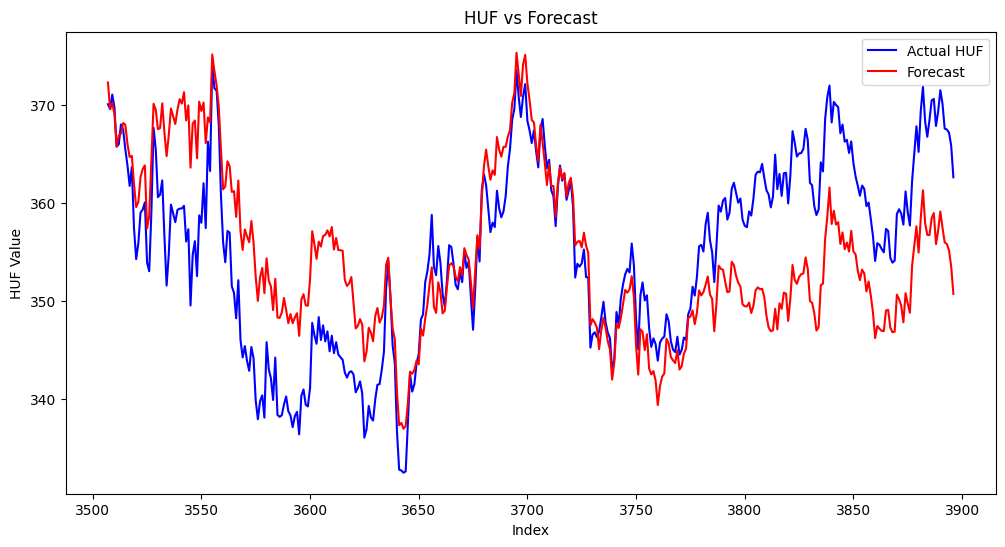

In [62]:
# Plot the actual values
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results['HUF=X'], label='Actual HUF', color='blue')

# Plot the forecasted values
plt.plot(df_results.index, df_results['Forecast'], label='Forecast', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('HUF Value')
plt.title('HUF vs Forecast')
plt.legend()

# Display the plot
plt.show()